# <span style="color:#AE74D4"> Multi Echo Gradient-recalled Echo simulations with synthetic quantitative MR maps with realistic SC WM and GM </span> </br>

In [21]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
from math import pi
from utils.sim_functions import complete_measurement

In [32]:
import importlib
import utils.sim_functions
importlib.reload(utils.sim_functions)

from utils.sim_functions import complete_measurement  # re-import updated function

## <span style="color:#EE6594"> *Complete Cropped signal equation - T1 // T 2* // PD & calculation of Flip Angle* </span> </br>
Using gaussian distribution in the spinal cords gray and white matter </br>

Completeing signal equation with T1 and TR block + the effect of the flip angle. <br>
Flip angle should be the ernst angle which by definition is the *arc cos* of exp(-TR/T1). Fixing TR leads to the FA needed to maximize signal from either GM or WM from the spinal cord. <br>

We compute the fieldmap with the whole-body field of view and then crop </br>
For this, we are using a bounding box and spinal cord toolbox </br>
x: [100, 400] </br>
y: [50, 400] </br>
z: [673, 800] </br>

This is good enough coverage of the cervical spine from brain to C5

Don't forget to create your header in matlab!

### <span style="color:#BC8EC4"> *Guassian Cropped simulation* </span> 

In [23]:
path_to_cropped_segmentations = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\added_new_tr_msk_ratatouille_cropped_segmentations.nii.gz"
path_to_cropped_pd = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_inputs\cropping/gauss_pd_sc_swiss_crop.nii.gz"
path_to_cropped_t1 = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_inputs\cropping/gauss_t1_sc_swiss_crop.nii.gz"
path_to_cropped_t2s = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_inputs\cropping/gauss_t2s_sc_swiss_crop.nii.gz"
path_to_cropped_fm_ppm = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_inputs\chi_to_fm_ppm\gauss_fm_ppm_sc_swiss_crop.nii.gz"
######### ####### # # ####### # # # # # # # # #### # # ### #
cropped_segmentations_img = nib.load(path_to_cropped_segmentations)
cropped_segmentations_data = cropped_segmentations_img.get_fdata()      
cropped_dimensions = np.array(cropped_segmentations_data.shape)
cropped_dimensions

array([301, 351, 128])

In [24]:
# Load nifti volumes
crop_pd_g_img = nib.load(path_to_cropped_pd)
crop_pd_g_data = crop_pd_g_img.get_fdata()

crop_t2s_g_img = nib.load(path_to_cropped_t2s)
crop_t2s_g_data = crop_t2s_g_img.get_fdata()

crop_t1_g_img = nib.load(path_to_cropped_t1)
crop_t1_g_data = crop_t1_g_img.get_fdata()

# This is the outcome of giving the susceptibility phantom to Susceptibility to Fieldmap repo
crop_deltaB0_pw_img = nib.load(path_to_cropped_fm_ppm)
crop_dB0_pw_ppm_data = crop_deltaB0_pw_img.get_fdata()

In [25]:
# Double check if dimensions match 
print(np.array(crop_pd_g_data.shape) == cropped_dimensions)
print(np.array(crop_t1_g_data.shape) == cropped_dimensions)
print(np.array(crop_t2s_g_data.shape) == cropped_dimensions)

[ True  True  True]
[ True  True  True]
[ True  True  True]


In [26]:
# Converting fm_ppm to Hz for Groun Truth comparison of BGFR algos:
# Can also be done in the BGFR tuner jup notebook
crop_ground_truth_ppm_img = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\bgfr_gt_ref_avg_sc_lf_ppm_crop.nii.gz")
crop_ground_truth_ppm_data = crop_ground_truth_ppm_img.get_fdata()
B0 = 3
f0_custom = 123.249 # From the json files of acquisitions with UNF Siemens 3T scanner 
f0_def = 42.58 * B0 # Assuming 3T and proton
#crop_dB0_pw_Hz_data = crop_dB0_pw_ppm_data * f0_def # Convert ppm to Hz
crop_ground_truth_Hz_data = crop_ground_truth_ppm_data * f0_def # Convert ppm to Hz 

In [27]:
crop_ground_truth_Hz_img = nib.Nifti1Image(crop_ground_truth_Hz_data, affine = crop_ground_truth_ppm_img.affine)
nib.save(crop_ground_truth_Hz_img, r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\ground_truth_data\bgfr_gt_ref_avg_sc_lf_Hz_crop.nii.gz")

In [28]:
# If f0 is not 127.47 MHz use this to calculate the B0 strength:
custom_B0 = f0_custom / 42.58
print(f"Custom B0 strength: {custom_B0} T")

Custom B0 strength: 2.8945279473931422 T


In [29]:
# Acquisition parameters:
t1_gm = 983.5
t1_wm = 857
#tr_custom= 45
#tr_swiss_acq = 926
new_swiss_tr = 38
fieldStrength = 3 # Tesla

#fa_swiss_acq = 44
swiss_mk2_fa_acq = 8

# Echo times must be in seconds
swiss_TE_list = [0.00685, 0.01085, 0.01485, 0.01885, 0.02285]
weird_TEs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.010, 0.015, 0.020, 0.030, 0.040] # This provides better T2* fit but is unrealistic.

In [30]:
# Usually we want the flip angle to be the Ernst angle, we can confirm what it should be after confirming our TR
best_fa = np.rad2deg(np.arccos(np.exp(-new_swiss_tr/((t1_gm+t1_wm)/2)))) # Degrees
print(f"Best FA with TR: {new_swiss_tr} is (GM+WM)/2: {best_fa}")

Best FA with TR: 38 is (GM+WM)/2: 16.352478694498664


In [62]:
import utils.sim_functions
importlib.reload(utils.sim_functions)

from utils.sim_functions import complete_measurement  # re-import updated function

In [60]:
qsm_processing_msk_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\qsm_processing_msk_crop.nii.gz"
noise_msk_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\noise_mask_crop.nii.gz"

In [73]:
cropped_pw_mag, cropped_pw_phase = complete_measurement(crop_t1_g_data, crop_pd_g_data, crop_t2s_g_data, cropped_dimensions, crop_dB0_pw_ppm_data , best_fa, weird_TEs, 
                                                        new_swiss_tr, fieldStrength, handedness= 'right', 
                                                        noise_flag = True, snr_target = 87, signal_msk_path = qsm_processing_msk_path, noise_msk_path = noise_msk_path)

Starting optimize_measurement
Flip angle used for:
sin($/alpha$):  0.2815457016971184
1-cos($/alpha$):  0.040452180526745596
Processing TE[0] = 0.001  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  0.8025665623199999j
High SNR regime
Sigma needed for 87:  0.1109666516603033
Finished optimized_signal with noise!
After adding noise, Measured SNR:  88.09539889388849
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[1] = 0.002  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  1.6051331246399998j
High SNR regime
Sigma needed for 87:  0.10942441712015047
Finished optimized_signal with noise!
After adding noise, Measured SNR:  87.70345346244186
mag shape: (301, 351, 128), phase_arr shape: (301, 351, 128)
Processing TE[2] = 0.003  [s]
Using T1, T2* and PD for simulation
handedness=right
Coefficient of phase factor:  2.4076996869599996j
High SNR regime
Sigma needed for 87:  0.10791944104052063

In [74]:
temp_crop_pw_mag = nib.Nifti1Image(cropped_pw_mag, affine = cropped_segmentations_img.affine)
temp_crop_pw_ph = nib.Nifti1Image(cropped_pw_phase, affine = cropped_segmentations_img.affine)

cropped_pw_magnitude_outpath = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_outputs/custom_params_snr_87/gauss_crop_sim_mag_pro.nii.gz"
cropped_pw_phase_outpath = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_outputs/custom_params_snr_87/gauss_crop_sim_ph_pro.nii.gz"

nib.save(temp_crop_pw_mag, cropped_pw_magnitude_outpath)
nib.save(temp_crop_pw_ph, cropped_pw_phase_outpath)

### Verify SNR on simulated magnitude in case the noise flag is used

In [71]:
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
parent_dir
sys.path.append(parent_dir)

In [67]:
from monkey_tools.snr_calc import snr_calc

In [76]:
cropped_pw_magnitude_outpath = r"E:\msc_data\sc_qsm\final_gauss_sims\November_2025\mrsim_outputs/custom_params_snr_57/gauss_crop_sim_mag_pro.nii.gz"
qsm_processing_msk_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\qsm_processing_msk_crop.nii.gz"
noise_msk_path = r"E:\msc_data\sc_qsm\final_gauss_sims\masks\noise_mask_crop.nii.gz"

gauss_noisy_sim_snr = snr_calc(cropped_pw_magnitude_outpath, qsm_processing_msk_path, noise_msk_path)
print("Noise for this noisy sim: ", gauss_noisy_sim_snr)

Noise for this noisy sim:  54.83065158995311


### A nice example of values which raise an overflow error in the exponential, interesting stuff!

In [ ]:
# This value was in the T2s volume because the gaussian distribution centered at 0.01
# Which was 'air' label created a few pixels with this offlayer values that caused the issue 
# returning infinity and hence ITK could not open the image
#np.exp(-0.008/-4.346339950507538e-06)

C:\Users\User\AppData\Local\Temp\ipykernel_83356\1727653921.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(-0.008/-4.346339950507538e-06)


inf

 # <span style="color:lime">Comparing simulations </span>

 Now, lets load the simulations created, we will use the next code to compare metrics between simulations. First comparing the magnitude and phase components and then loading QSM results and comparing metrics for white and gray matter.

In [24]:
gm_mask_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/gm_mask_crop.nii.gz")
gm_mask_data = gm_mask_img.get_fdata()
wm_mask_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus/wm_mask_crop.nii.gz")
wm_mask_data = wm_mask_img.get_fdata()

In [25]:
custom_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal/gauss_crop_sim_mag_pro.nii.gz")
custom_params_sim_mag_data = custom_params_sim_mag_img.get_fdata()
#custom_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_ideal/gauss_crop_sim_ph_pro.nii.gz")
#custom_params_sim_ph_data = custom_params_sim_ph_img.get_fdata()

swiss_params_sim_mag_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss_crop_sim_mag_pro.nii.gz")
swiss_params_sim_mag_data = swiss_params_sim_mag_img.get_fdata()
#swiss_params_sim_ph_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss/gauss_crop_sim_ph_pro.nii.gz")
#swiss_params_sim_ph_data = swiss_params_sim_ph_img.get_fdata()

In [27]:
n_echoes_custom = custom_params_sim_mag_data.shape[-1]
n_echoes_swiss = swiss_params_sim_mag_data.shape[-1]

In [28]:
wm_ideal_mean = []
gm_ideal_mean = []

wm_swiss_mean = []
gm_swiss_mean = []

for i in range(n_echoes_custom):
    wm_custom_vals = custom_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_custom_vals = custom_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_ideal_mean.append(np.mean(wm_custom_vals))
    gm_ideal_mean.append(np.mean(gm_custom_vals))

for i in range(n_echoes_swiss):
    wm_swiss_vals = swiss_params_sim_mag_data[..., i][wm_mask_data==1]
    gm_swiss_vals = swiss_params_sim_mag_data[..., i][gm_mask_data==1]

    wm_swiss_mean.append(np.mean(wm_swiss_vals))
    gm_swiss_mean.append(np.mean(gm_swiss_vals))

In [29]:
swiss_TE_seconds = [6.86, 13.14, 19.42, 25.7, 31.98]
customs_TE_seconds = [1, 2, 3, 4, 5, 10, 15, 20, 30, 40] 

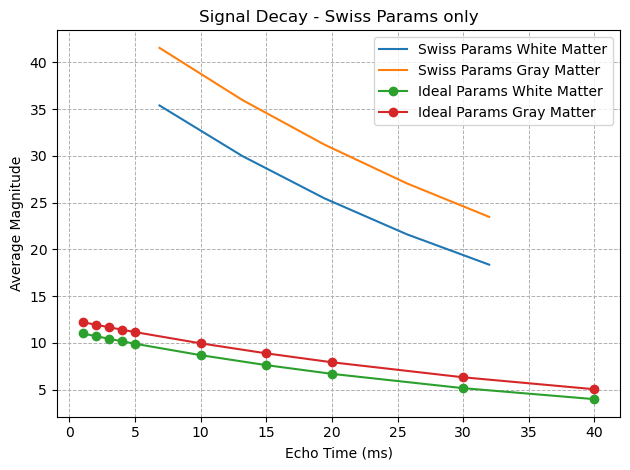

In [31]:
plt.plot(swiss_TE_seconds, wm_swiss_mean, label='Swiss Params White Matter')
plt.plot(swiss_TE_seconds, gm_swiss_mean, label='Swiss Params Gray Matter')
plt.plot(customs_TE_seconds, wm_ideal_mean,'o-', label='Ideal Params White Matter')
plt.plot(customs_TE_seconds, gm_ideal_mean,'o-', label='Ideal Params Gray Matter')
plt.xlabel('Echo Time (ms)')
plt.ylabel('Average Magnitude')
plt.title('Signal Decay - Swiss Params only')
plt.legend()

plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.yticks()
plt.show()

## <span style="color:#009688">QSM and proceesing steps analysis</span>

### <span style="color:#9575CD">Fieldmap comparison</span>

Values for ideal FM processed with ROMEO have negative values around -400 Hz </br>
Values for swiss FM processed with ROMEO show values near 0 Hz </br>
Perhaps a n*pi offset correction is required.

In [33]:
swiss_TE_seconds[1] - swiss_TE_seconds[0]

6.28

In [39]:
# It looks like there is a n*pi phase wrap happening,
B0=3
central_freq_3T = 42.58*B0 # MHz used at the desired B0
n = 1
gamma = 267.53803037970675 # rad/s.T
delta_TE_swiss = swiss_TE_seconds[1] - swiss_TE_seconds[0]
freq_offset_npi = (n*np.pi)/(delta_TE_swiss*1e-3)
print(f"Frequency offset from a {n} pi wrap: ", freq_offset_npi, " Hz for Swiss FM processed with ROMEO")

Frequency offset from a 1 pi wrap:  500.2536072595212  Hz for Swiss FM processed with ROMEO


In [36]:
# Load the fieldmap and correct for 1 pi phase wrap
gauss_swiss_romeo_fm_img = nib.load(r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss\fm_tests\test2_msk_apply/B0.nii")
gauss_swiss_romeo_fm_data = gauss_swiss_romeo_fm_img.get_fdata()

gauss_swiss_romeo_fm_corrected = gauss_swiss_romeo_fm_data - freq_offset_npi
gauss_swiss_romeo_fm_corrected_img = nib.Nifti1Image(gauss_swiss_romeo_fm_corrected, affine = gauss_swiss_romeo_fm_img.affine)
nib.save(gauss_swiss_romeo_fm_corrected_img, r"E:\msc_data\sc_qsm\new_gauss_sims\mrsim_outpus\cropped_swiss\fm_tests\test2_msk_apply/B0_corrected.nii.gz")

# <span style="color:#EE6594"> *Splitting magnitude and phase echoes* </span> </br>


In [4]:
# Load mag and phase
cMag = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\gauss_crop_sim_mag_pro.nii.gz")
cPhs = nib.load(r"E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\gauss_crop_sim_ph_pro.nii.gz")
outfolder = r"E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation"

In [5]:
cMag_data = cMag.get_fdata()
cPhs_data = cPhs.get_fdata()    
affine = cMag.affine
num_echoes = cMag_data.shape[-1]
print(f"Number of echoes detected: {num_echoes}")

Number of echoes detected: 10


In [ ]:
for e in range(num_echoes):
    # Extract each echo
    mag_echo = cMag_data[..., e]
    phase_echo = cPhs_data[..., e]

    # Create Nifti objects
    mag_echo_img = nib.Nifti1Image(mag_echo, affine)
    phase_echo_img = nib.Nifti1Image(phase_echo, affine)

    # Save
    mag_out = os.path.join(outfolder, f"magnitude_echo{e+1}.nii.gz")
    phase_out = os.path.join(outfolder, f"phase_echo{e+1}.nii.gz")

    nib.save(mag_echo_img, mag_out)
    nib.save(phase_echo_img, phase_out)

    print(f"Saved: {mag_out}")
    print(f"Saved: {phase_out}")

Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\magnitude_echo1.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\phase_echo1.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\magnitude_echo2.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\phase_echo2.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\magnitude_echo3.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\phase_echo3.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\magnitude_echo4.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_sims\August_2025\mrsim_outputs\custom_params\echo_separation\phase_echo4.nii.gz
Saved: E:\msc_data\sc_qsm\final_gauss_si